In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
#import splitfolders
#splitfolders.ratio('Forest_AnnualCrop_Highway', output="output", seed=1337, ratio=(.8, 0,0.2))

In [4]:
dataset_path_train = "C:\\Users\\andre\\Desktop\\EuroSAT\\output\\train" 
dataset_path_test = "C:\\Users\\andre\\Desktop\\EuroSAT\\output\\test" 

In [5]:
def SIFT_features(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    sift  = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        descriptors = np.zeros((1,128))
    return keypoints, descriptors

In [6]:
def SIFT_features_from_dateset(dataset_path):
    keypoints = []
    descriptors = []
    for dirname in os.listdir(dataset_path):
        for subdir in os.listdir(dataset_path + '\\' + dirname):
            image_path = (dataset_path + '\\' + dirname + '\\' + subdir)
            kp, desc = SIFT_features(image_path)
            keypoints.append(kp)
            descriptors.append(desc)
    return keypoints, descriptors

In [7]:
def kmeans(num_clusters, descriptors_list):
    kmeans = KMeans(n_clusters = num_clusters, n_init=10)
    kmeans.fit(descriptors_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words

In [8]:
def compute_histograms(descriptors_list, visual_words, num_clusters):
    histograms_list = []
    
    for descriptors in descriptors_list:
        labels, _ = vq(descriptors, visual_words)
        histogram, _ = np.histogram(labels, bins = range(num_clusters + 1))
        histograms_list.append(histogram)
    
    return np.array(histograms_list)

In [9]:
def define_class(dataset_path):
    class_labels = []
    for dirname in os.listdir(dataset_path):
        for subdir in os.listdir(os.path.join(dataset_path, dirname)):
        
            if 'Forest' in subdir[:6]:
                class_labels.append('1')  
            elif 'AnnualCrop' in subdir[:10]:
                class_labels.append('2')
            elif 'Highway' in subdir[:7]:
                class_labels.append('3')

    return class_labels

In [10]:
def accuracy_score_classes():
    
    matrix = confusion_matrix(y_test, y_pred)
    acc_score = matrix.diagonal()/matrix.sum(axis=1)
    
    print(f'Accuracy score for class Forest: {100 * acc_score[0]:.2f} %')
    print(f'Accuracy score for class AnnualCrop: {100 * acc_score[1]:.2f} %')
    print(f'Accuracy score for class Highway: {100 * acc_score[2]:.2f} %')

In [11]:
keypoints_list_train, descriptors_list_train = SIFT_features_from_dateset(dataset_path_train)
keypoints_list_test, descriptors_list_test = SIFT_features_from_dateset(dataset_path_test)

In [12]:
descriptors_array_train = np.vstack(descriptors_list_train)
descriptors_array_test = np.vstack(descriptors_list_test)

In [13]:
num_of_clusters = 20
visual_words = kmeans(num_of_clusters, descriptors_array_train)

In [14]:
histograms_train = compute_histograms(descriptors_list_train, visual_words, num_of_clusters)
histograms_test = compute_histograms(descriptors_list_test, visual_words, num_of_clusters)

In [15]:
histograms_test.shape

(1700, 20)

In [16]:
classes = define_class(dataset_path_train)

In [17]:
y_test = define_class(dataset_path_test)

In [18]:
from sklearn.svm import LinearSVC
clf=LinearSVC(max_iter=80000)
clf.fit(histograms_train,classes)

C:\Users\andre\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(max_iter=80000)

In [19]:
y_pred=clf.predict(histograms_test)

In [20]:
accuracy=accuracy_score(y_test,y_pred)
print(accuracy)

0.8488235294117648


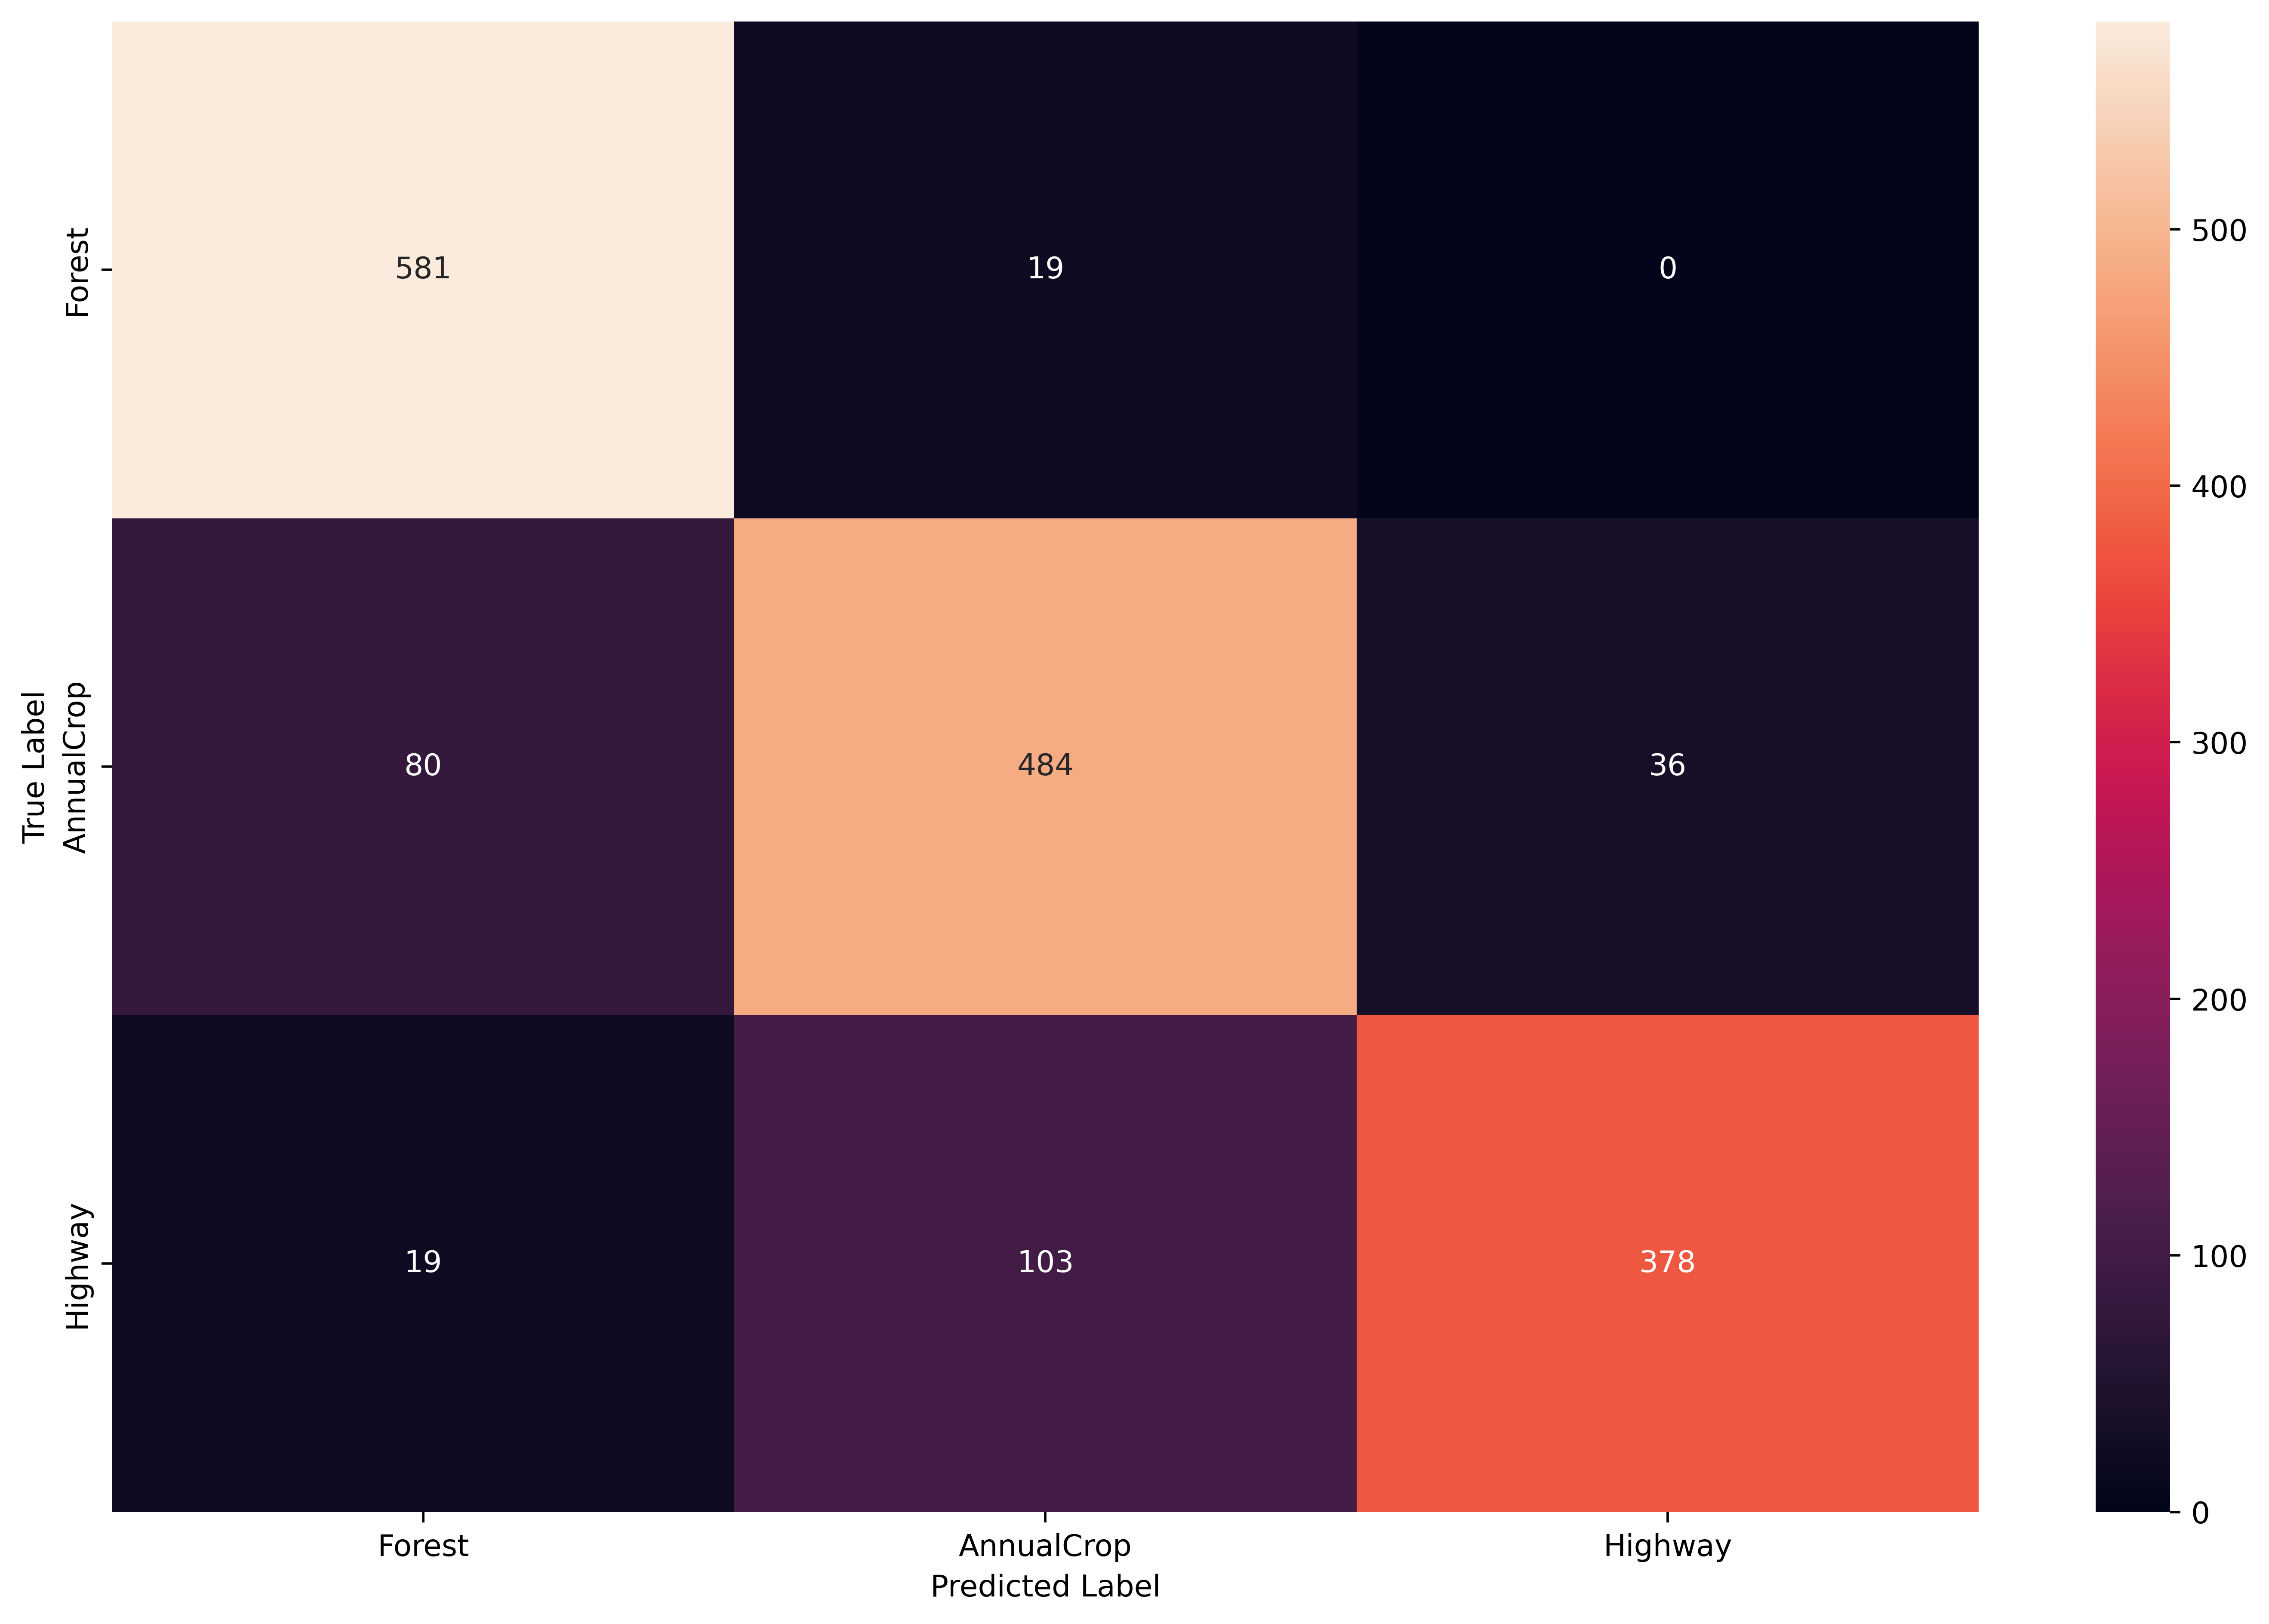

In [21]:
classes = ['Forest','AnnualCrop','Highway']
plt.figure(figsize=(14,9),dpi=500)
ax = sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,
                 xticklabels=classes,yticklabels=classes,fmt='d')
ax.set(xlabel="Predicted Label", ylabel="True Label")
plt.show()

In [22]:
print(f"Accuracy score: {100 * accuracy_score(y_test, y_pred):.2f} %")
accuracy_score_classes()
print('\n')
print(classification_report(y_test,y_pred))

Accuracy score: 84.88 %
Accuracy score for class Forest: 96.83 %
Accuracy score for class AnnualCrop: 80.67 %
Accuracy score for class Highway: 75.60 %


              precision    recall  f1-score   support

           1       0.85      0.97      0.91       600
           2       0.80      0.81      0.80       600
           3       0.91      0.76      0.83       500

    accuracy                           0.85      1700
   macro avg       0.86      0.84      0.85      1700
weighted avg       0.85      0.85      0.85      1700

